##**HOMEWORK 05**
### IANNWTF - CNN (optimization)
###Group 02

In this notebook we implement a Convolutional Neural Network (CNN) using keras and train it on the [Cifar10 dataset](https://www.cs.toronto.edu/%7Ekriz/cifar.html) in order to classify images amoung ten categories. 

In [1]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import time 
# print(tf.__version__)

###**Useful Function**###

Here there are some functions we will use later one for visualization.

In [2]:
# Function to plot some images from the data 
def plot_images(images, num_labels, name_label, row, col):
  ''' Creates a visualization of a given amount of images and match their numeric labels 
  to the respective name label given in a string list.

  Arguments:
  ---------
  images (ndarray) = a set of iterable images.
  num_labels (ndarray) = a set of numeric labels.
  name_label (list) = a list of ordered string names matching the numeric labels.
  row (int) = amount of rows.
  col (int) = amount of columns.
  '''

  fig, ax = plt.subplots(row,col, figsize = (18,8))
  fig.tight_layout(h_pad=2.5)
  ax = ax.flatten()

  for i in range(row * col):
    # Match the train_labels with their names labels
    for j, value in enumerate(name_label):
      if j == num_labels[i]:
        lbl = value
    # take an image, its label and corresponding shape.
    img = images[i]
    shp = images[i].shape

    # plot the image and corresponding information
    ax[i].imshow(img)
    ax[i].title.set_text(f'{lbl} \n{shp}')
    ax[i].axis("off")

In [47]:
# Plot training and test loss.
def plot_accuracy(train_losses,test_losses,test_accuracies):
  '''Creates a visualization of the training and testing losses as well as the testing accuracy

  Arguments:
  ---------
  train_losses (list) = training loss from a list.
  test_losses (list) = testing loss from a list.
  test_accuracies (list) = mean of the test accuracies. latest accuracy optained. 

  '''
  plt.figure()
  line1, = plt.plot(train_losses)
  line2, = plt.plot(test_losses)
  plt.xlabel("Training steps")
  plt.ylabel("Loss")
  plt.legend((line1,line2),("training","test"))
  plt.show()

  # Plot training and test accuracy.
  plt.figure()
  line1, = plt.plot(test_accuracies)
  plt.title(f'Total Acuraccy: {np.max(test_accuracies)}')
  plt.xlabel("Training steps")
  plt.ylabel("Accuracy")
  plt.show()

###**1. Load Data**
The Cifar10 dataset contains a total of 60.000 colored images of different objects and animals with equal sizes. We will build the model and train it to classify the images. However, before that, we will preprocess the images and assign them their respective "name label".

In [51]:
# Load the dataset 
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

Let's explore the data by doing some usefull prints.

In [4]:
print(type(train_images))
print(train_images.shape, train_labels.shape)
print(f'Image size = {train_images[0].shape}')
print(f'Minimun = {np.min(train_images[0])}, \nMaximun = {np.max(train_images[0])}')
print(test_images.shape, test_labels.shape)

<class 'numpy.ndarray'>
(50000, 32, 32, 3) (50000, 1)
Image size = (32, 32, 3)
Minimun = 0, 
Maximun = 255
(10000, 32, 32, 3) (10000, 1)


Now, let's visualize some of the images with their respective labels using the funtions we created above.

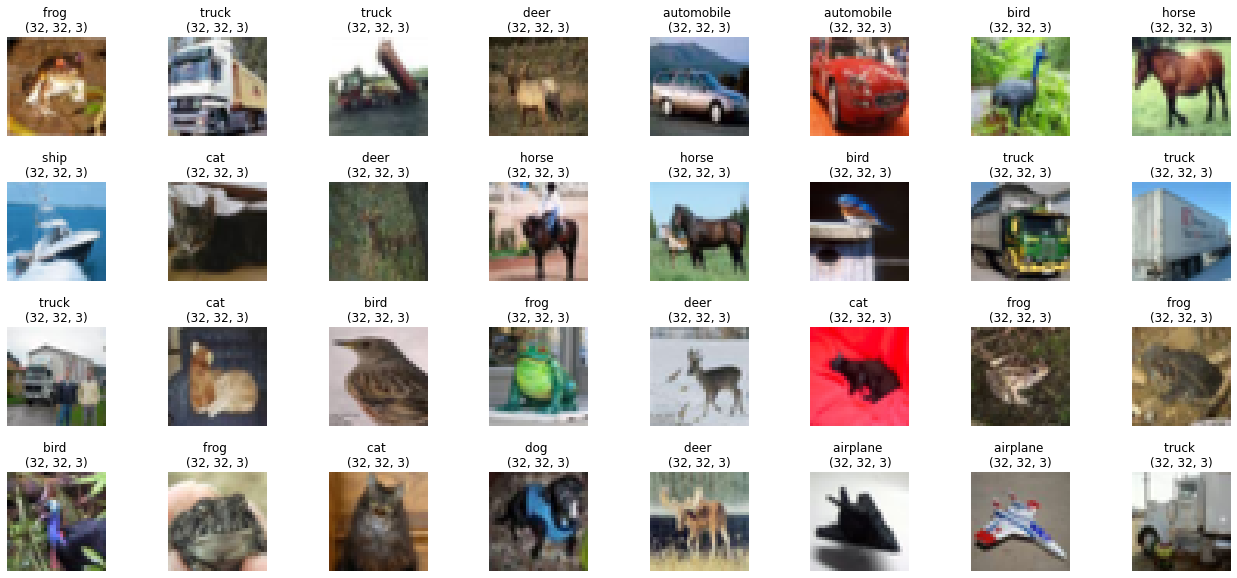

In [5]:
# Set the label names for the images
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Visualize some of the images
plot_images(train_images, train_labels, labels, 4, 8)

###**1.1 Preprocessing**
Here we normalize the images so that they are in a range between 0 and 1. For that we will use the built-in function from tensorflow which allow us to convert between data types, scaling the values appropriately before casting

In [52]:
# This puts the image values in range between 0 and 1 for float conversion
train_images = tf.image.convert_image_dtype(train_images, tf.float32)
test_images = tf.image.convert_image_dtype(test_images, tf.float32)

# Let's check the normalized images 
print(type(train_images))
print(f'Minimun = {np.min(train_images[0])}, \nMaximun = {np.max(train_images[0])}\n')
# print(train_images[0])

<class 'tensorflow.python.framework.ops.EagerTensor'>
Minimun = 0.0, 
Maximun = 1.0



##**2. Build the Tensorflow dataset: Input pipeline**

In [53]:
# 1. Create a tf.dataset train_dataset_seq from a train tensor images
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)

train_dataset_labels = tf.data.Dataset.from_tensor_slices(train_labels)
# we want the labels to be onehot encoded
train_dataset_labels = train_dataset_labels.map(lambda t : tf.one_hot(t, 10))
# reshape the labels 
train_dataset_labels = train_dataset_labels.map(lambda l : tf.reshape(l, (-1,)))

# zip together input and labels
train_dataset = tf.data.Dataset.zip((train_dataset_images, train_dataset_labels))
train_dataset = train_dataset.shuffle(buffer_size=128)
train_dataset = train_dataset.batch(22)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 2. repeat for test dataset

test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)


test_dataset_labels = tf.data.Dataset.from_tensor_slices(test_labels)
test_dataset_labels = test_dataset_labels.map(lambda t : tf.one_hot(t, 10))
test_dataset_labels = test_dataset_labels.map(lambda l : tf.reshape(l, (-1,)))

# zip together both input and labels 
test_dataset = tf.data.Dataset.zip((test_dataset_images, test_dataset_labels))
test_dataset = test_dataset.shuffle(buffer_size=128)
test_dataset = test_dataset.batch(22)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [54]:
print(train_dataset_images)

<TensorSliceDataset shapes: (32, 32, 3), types: tf.float32>


##**3. Build the model**

In the following steps we will implement a Convolutional Neural Network in order to do the classification of the cells. First, we will implement a fully connected feedforward network. 
For our network we we will use:
        **Two Convolutions**
        self.conv_1(x)
        relu(x)
        conv_1_1(x)
        con1_1_batch_n(x, training)
        relu(x)
        self.max_pool_1(x)

        **Two Convolutions**
        Convolution 3-4
        conv_2(x)
        con2_batch_n(x, training)
        relu(x)
        conv_2_2(x)
        con2_2_batch_n(x, training)
        relu(x)
        max_pool_2(x) 
        dropout_2(x, training) 
    
        **Two Convolutions**
        conv_3(x)
        con3_batch_n(x, training)
        relu(x)
        conv_4(x)
        con4_batch_n(x, training)
        relu(x)
        max_pool_4(x)  
        dropout_2(x, training) 
        
        **One Convolution**
        conv_5(x)
        con5_batch_n(x, training)
        relu(x)
        max_pool_5(x)  

        **Global pooling and 1 hidden**
        global_pool(x)
        hidden_layer1(x)
        dropout(x, training)

        **Output layer**
        output_layer(x)

In [58]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # activation = tf.nn.leaky_relu
        # Define the layers as follows.
        self.conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3,
                                             padding = 'valid',
                                             activation=None,
                                             input_shape=(32,32,3)
                                             )
        self.conv_1_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3,
                                             padding = 'same',
                                             activation=None
                                             )
        self.con1_1_batch_n = tf.keras.layers.BatchNormalization()
        self.max_pool_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2),
                                                    strides = (1,1))
        
        
        self.conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                             padding = 'same',
                                             activation=None
                                             )
        # Define batch normalization layer
        self.con2_batch_n = tf.keras.layers.BatchNormalization()

        self.conv_2_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                             padding = 'same',
                                             activation=None
                                             )
        # Define batch normalization layer and so on for the other layers
        self.con2_2_batch_n = tf.keras.layers.BatchNormalization()
        self.max_pool_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2),
                                                    strides = (2,2))

        self.conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3,
                                             padding = 'same',
                                             activation=None
                                             )
        self.con3_batch_n = tf.keras.layers.BatchNormalization()
        self.max_pool_3 = tf.keras.layers.MaxPool2D(pool_size=(2,2),
                                                    strides = (2,2))

        self.conv_4 = tf.keras.layers.Conv2D(filters=128, kernel_size=3,
                                             padding = 'same',
                                             activation=None
                                             )
        self.con4_batch_n = tf.keras.layers.BatchNormalization()
        self.max_pool_4 = tf.keras.layers.MaxPool2D(pool_size=(2,2),
                                                    strides = (2,2))

        self.conv_5 = tf.keras.layers.Conv2D(filters=256, kernel_size=3,
                                             padding = 'same',
                                             activation=None,
                                             )
        self.con5_batch_n = tf.keras.layers.BatchNormalization()
        
        self.max_pool_5 = tf.keras.layers.MaxPool2D(pool_size=(2,2), 
                                                    strides=(2,2))


        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.hidden_layer1 = tf.keras.layers.Dense(1024,
                                                  activation= tf.keras.activations.relu
                                                  )

        self.output_layer = tf.keras.layers.Dense(10,
                                                  activation = tf.keras.activations.softmax
                                                  )
        self.dropout = tf.keras.layers.Dropout(rate=0.5)
        self.dropout_2 = tf.keras.layers.Dropout(rate=0.3)
        # self.relu = tf.keras.activations.relu
        self.relu = tf.nn.leaky_relu
    @tf.function
    def call(self, x, training=True):
        # Define the forward step.
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.conv_1_1(x)
        x = self.con1_1_batch_n(x, training)
        x = self.relu(x)
        x = self.max_pool_1(x)

        x = self.conv_2(x)
        x = self.con2_batch_n(x, training)
        x = self.relu(x)
        x = self.conv_2_2(x)
        x = self.con2_2_batch_n(x, training)
        x = self.relu(x)
        x = self.max_pool_2(x) 
        x = self.dropout_2(x, training) 
    
        x = self.conv_3(x)
        x = self.con3_batch_n(x, training)
        x = self.relu(x)

        x = self.conv_4(x)
        x = self.con4_batch_n(x, training)
        x = self.relu(x)
        x = self.max_pool_4(x)  
        x = self.dropout_2(x, training) 
        
        x = self.conv_5(x)
        x = self.con5_batch_n(x, training)
        x = self.relu(x)
        x = self.max_pool_5(x)  

        x = self.global_pool(x)
        x = self.hidden_layer1(x)
        x = self.dropout(x, training)

        x = self.output_layer(x)
        return x

###**4. Train the Model**

In [46]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function, training = False):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input, training)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

Epoch: __ 0


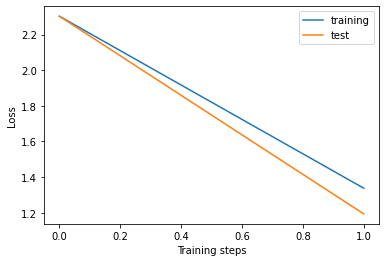

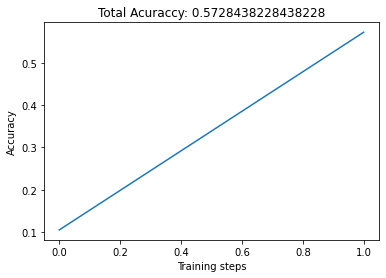

Epoch: __ 1


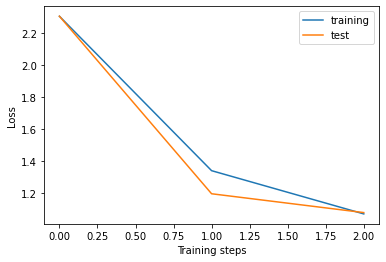

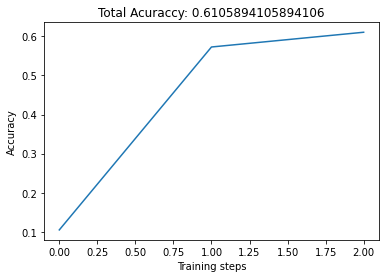

Epoch: __ 2


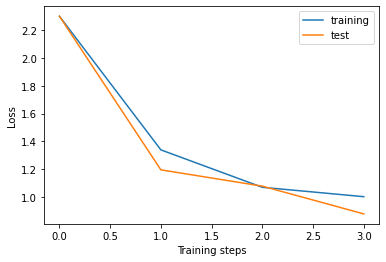

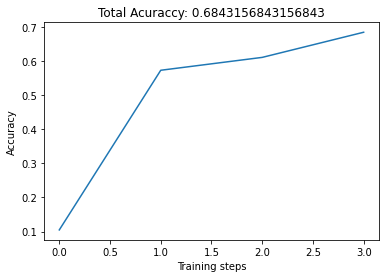

Epoch: __ 3


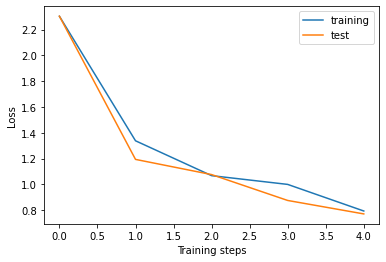

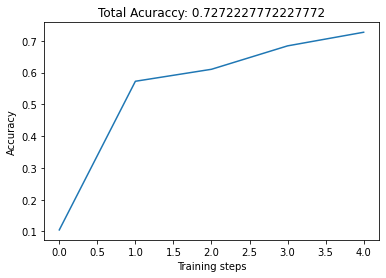

Epoch: __ 4


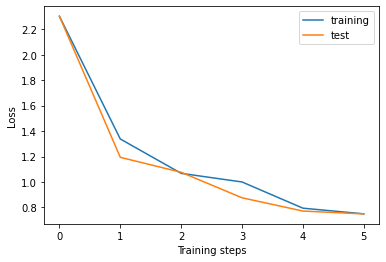

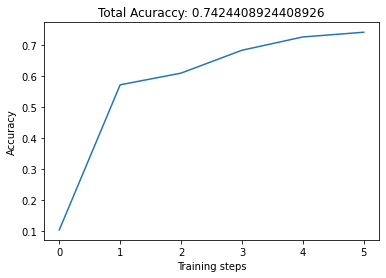

Epoch: __ 5


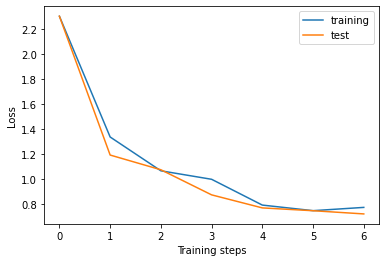

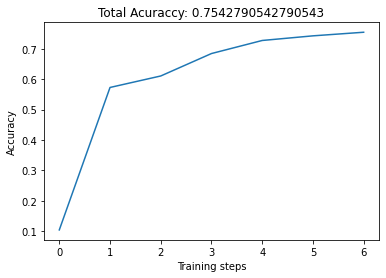

Epoch: __ 6


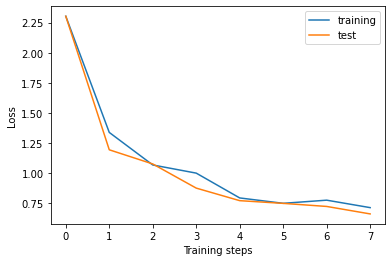

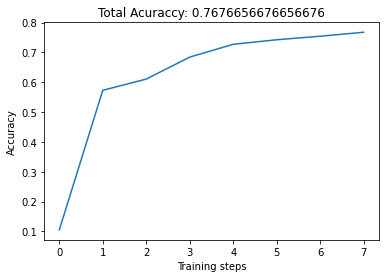

Epoch: __ 7


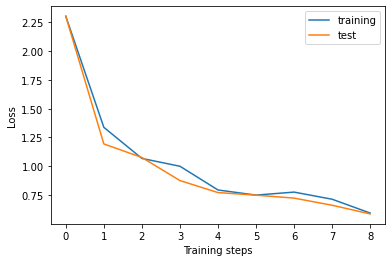

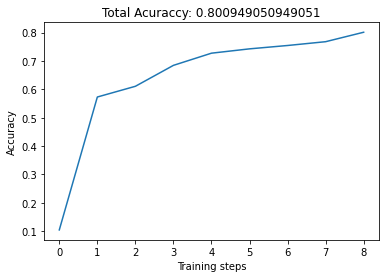

Epoch: __ 8


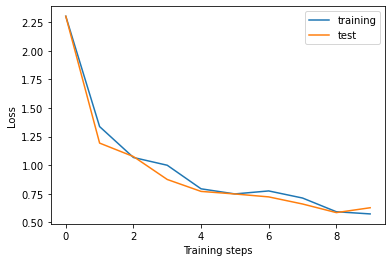

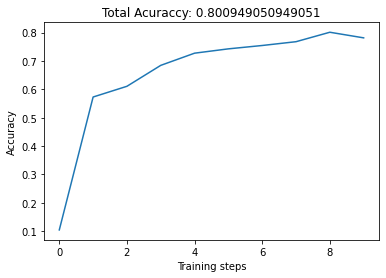

Epoch: __ 9


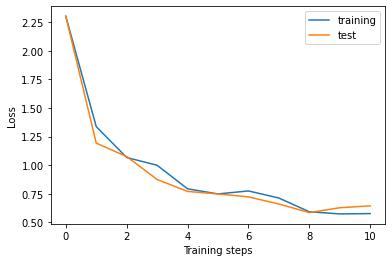

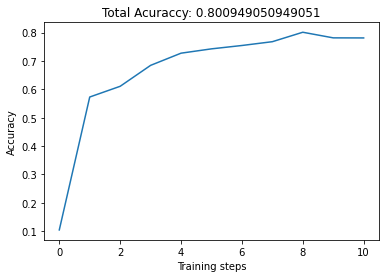

Epoch: __ 10


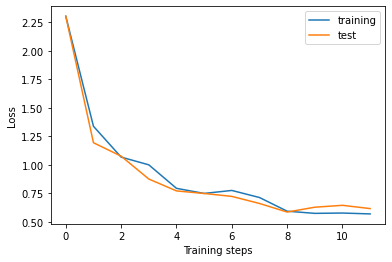

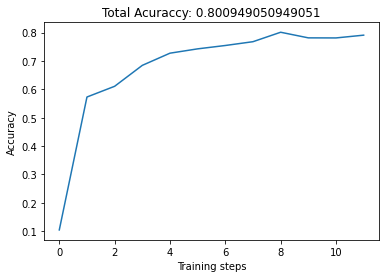

Epoch: __ 11


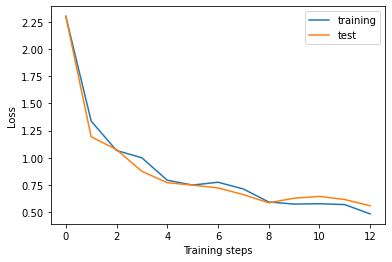

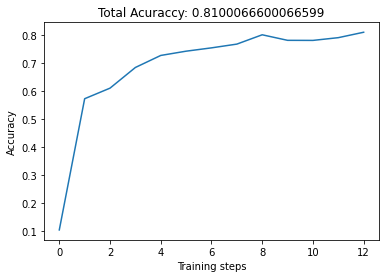

Epoch: __ 12


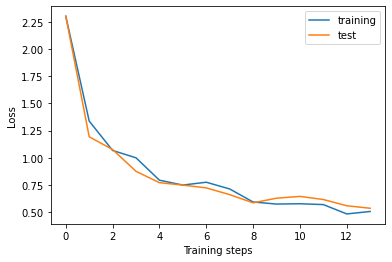

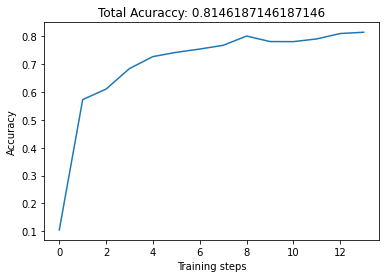

Epoch: __ 13


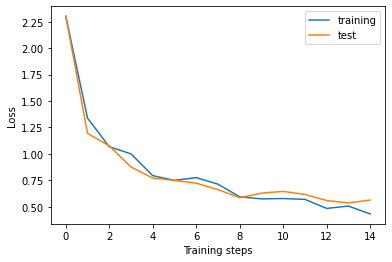

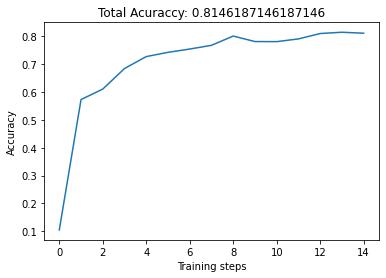

Epoch: __ 14


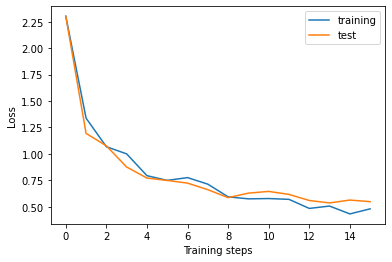

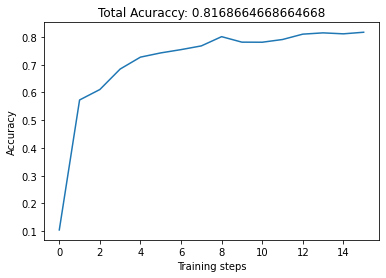

Epoch: __ 15


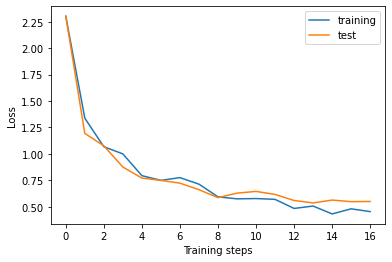

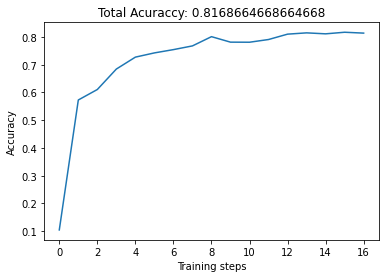

Epoch: __ 16


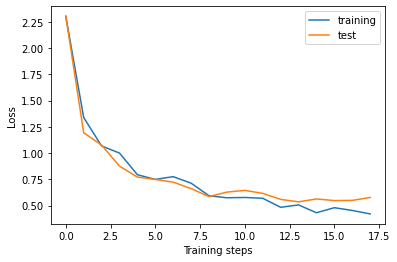

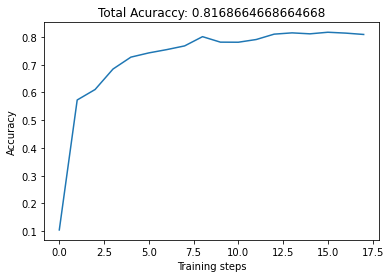

Epoch: __ 17


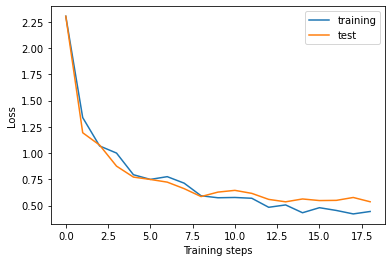

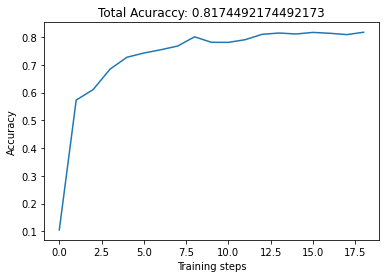

Epoch: __ 18


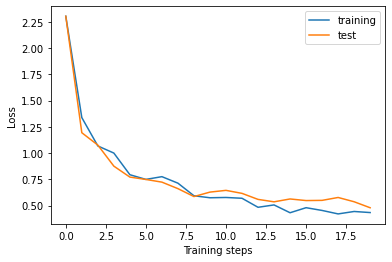

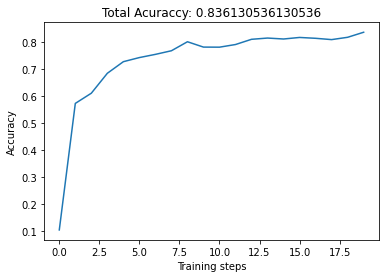

Epoch: __ 19


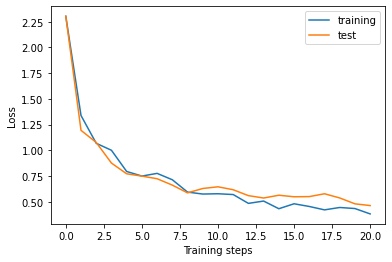

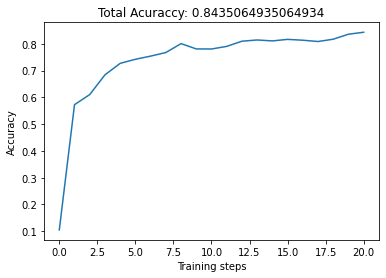

Epoch: __ 20


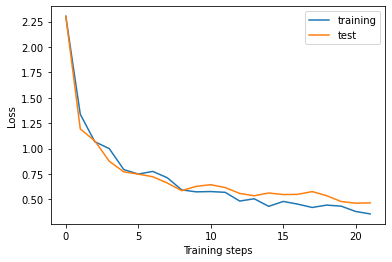

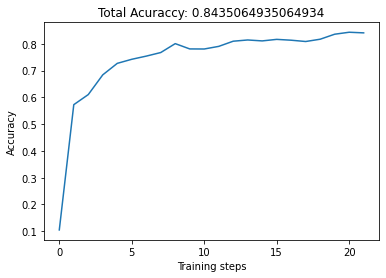

Epoch: __ 21


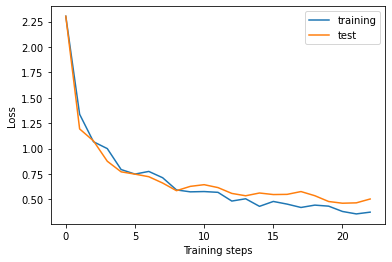

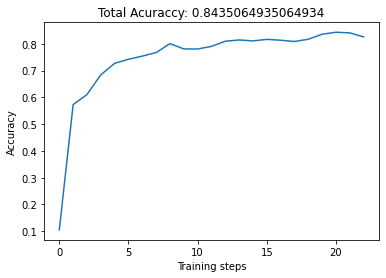

Epoch: __ 22


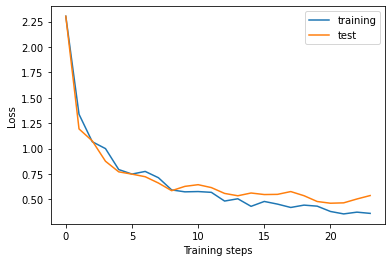

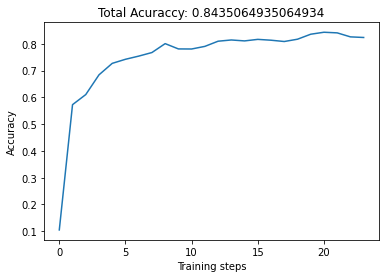

Epoch: __ 23


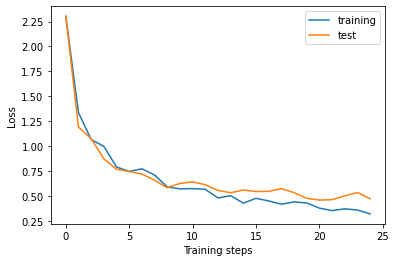

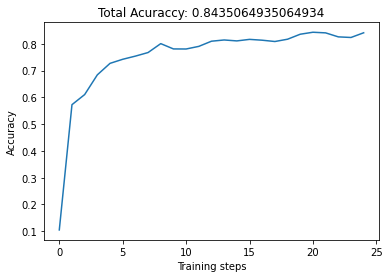

Epoch: __ 24


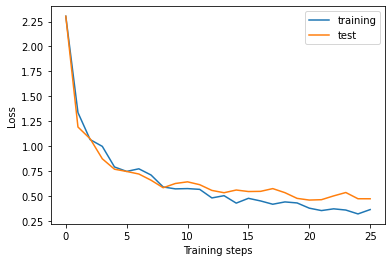

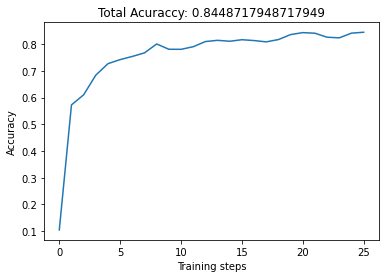

Epoch: __ 25


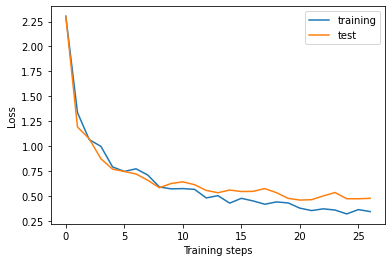

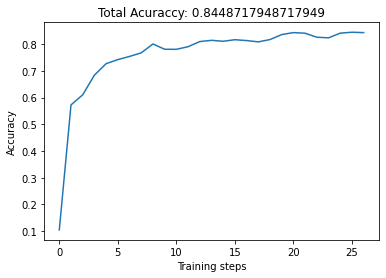

Epoch: __ 26


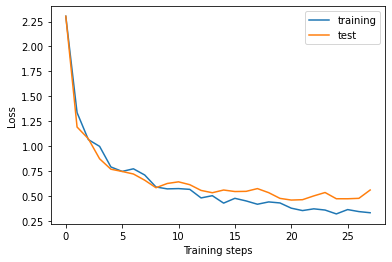

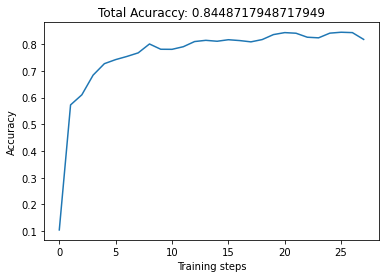

Epoch: __ 27


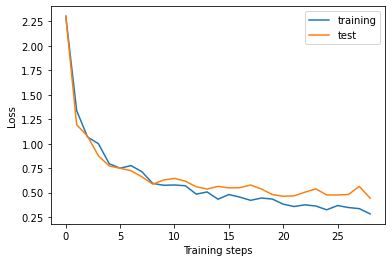

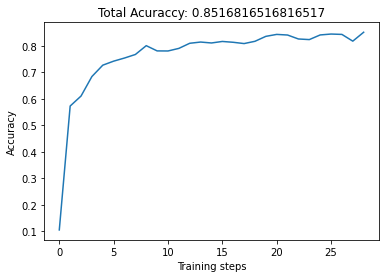

Epoch: __ 28


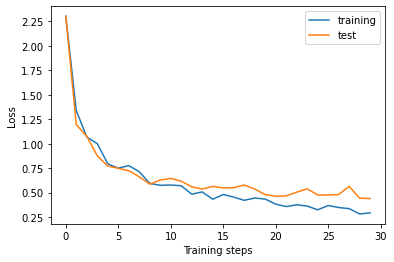

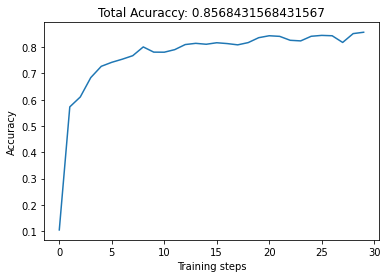

Epoch: __ 29


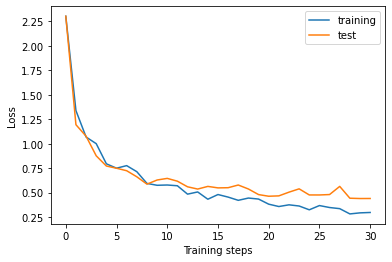

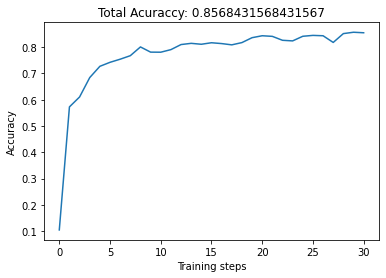


This training took: 20 minutes and 19.356781482696533 seconds.


In [48]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 30
learning_rate = 0.0001
running_average_factor = 0.95

# Set the time
start = time.time()

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    plot_accuracy(train_losses, test_losses, test_accuracies)

# Keep track of the time 
end = time.time()
duration = end - start

print(f'\nThis training took: {int (duration / 60)} minutes and {(duration % 60)} seconds.')

###**5. Visualizing the Process**
Finally, we can visualize the accuracy and loss for both training test data.

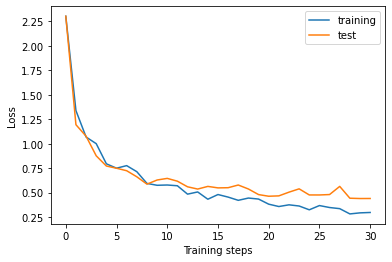

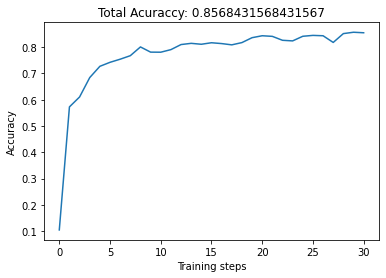

In [49]:
# Plot training and test loss.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

# Plot training and test accuracy.
plt.figure()
line1, = plt.plot(test_accuracies)
plt.title(f'Total Acuraccy: {np.max(test_accuracies)}')
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()


## Save the Model
Finally, we will save our model given its great performance. This way we can keep all the para meters it has learn so far (such as weights) so that we can use them later on.

In [60]:
model.save_weights('Cifar10_cnn_85.h5')